In [1]:
import numpy as np
from collections import OrderedDict

import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import pygam
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from lookahead import Lookahead
import uncert
import pred
import prop
from models import polyRegression

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the diabetes dataset

In [2]:
#load data
data_bunch = load_diabetes()
x,y0 = data = load_diabetes(return_X_y=True)
y0 = -y0
y0 = (y0-np.min(y0))/(np.max(y0)-np.min(y0))
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose linearGAM model as f*

In [3]:
lams = np.random.rand(100, x.shape[1])
lams = lams * 6 - 3
lams = np.exp(lams)
fstar = pygam.LinearGAM(n_splines=12, max_iter=100).gridsearch(x, y0, lam=lams)
y = fstar.predict(x) 
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


[f*] mse(y,y0): 0.02439169004541948
[f*] mae(y,y0): 0.12523122751226914


<Figure size 432x288 with 0 Axes>

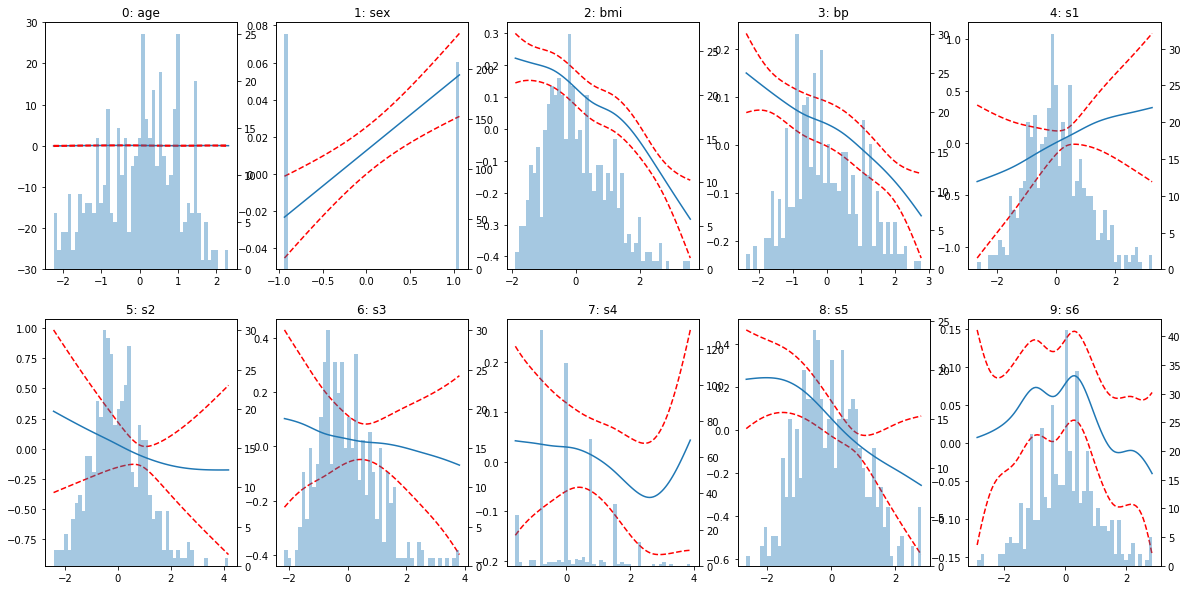

In [4]:
titles = data_bunch.feature_names
titles_idx = [str(i)+': '+titles[i] for i in range(len(titles))]

plt.figure()
fig, axs = plt.subplots(2,5,figsize=(20, 10))
for i, ax in enumerate(axs.flatten()[:x.shape[1]]):
    XX = fstar.generate_X_grid(term=i)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX))
    ax2 = ax.twinx()
    ax2.hist(x[:, i], alpha=.4, bins=50) #, density=True)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles_idx[i])
plt.show()

## Generating the train-test splits

In [5]:
# split data
seed = 1
trn_sz = 0.75 # working-set relative size
active = np.arange(n) # No sub-sampling

x_active = x[active,:]
# y_active = y[active]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst, idx_trn, idx_tst = train_test_split(x_active, y_active, active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 442 , n_active: 442 , n_trn: 331 , n_tst: 111


## Setting the hyperparamters of the look ahead model

In [6]:
# Step Size
eta = 5. 

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])
alphas_sub = [0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-7,-1,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 2 and 4 are the only non-immutable features
mask = np.zeros(d)
mask[[2,4]] = 1

# Degree of the polynomial to be used for regression
deg = 2

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.05
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20 
# Learning rate
lr_g = 0.05
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

t: 0
[f] mse: 0.0279, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0293
[f] improve*: 0.029



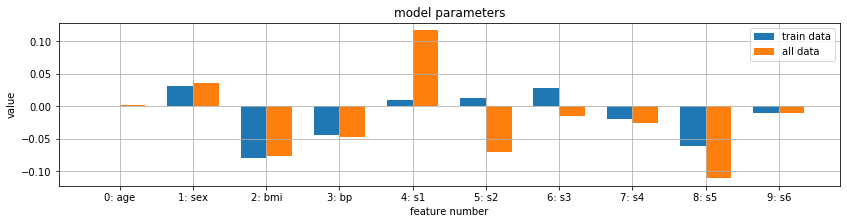

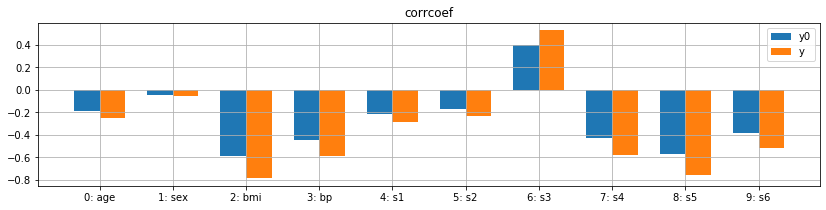

baseline: (skl)
		trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0026
mae	0.1375	0.1317	0.1361	0.0401

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0026
mae	0.1375	0.1317	0.1361	0.0401
imprv	0.0285	0.0443	0.0325	0.0325
imprt	0.5529	0.6126	0.5679	1.0000

best reg coef: 32.0 , idx: 14


In [7]:
# baselines
verbose = True

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type=reg_type, alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_base)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl,alpha=1,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench,alpha=1,width=barWidth)
plt.xticks(np.arange(d),titles_idx)
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()


cor_y0 = [np.corrcoef(x[:,i],y0)[0,1] for i in range(d)]
cor_y = [np.corrcoef(x[:,i],y)[0,1] for i in range(d)]
plt.bar(np.arange(d)-barWidth/2,cor_y0,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,cor_y,width=barWidth)
plt.title('corrcoef')
plt.legend(['y0','y'])
plt.xticks(np.arange(d),titles_idx)
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
    perf_base['imprate'].append(model_base.improve_rate(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Training the lookahead model for different values of l2-regularizer coefficient

In [8]:
# train our model
verbose = True

#==TEMP==
# alphas_sub = [1e-7]
# lams = [0, 0.01, 0.05]
# num_cycles = 5
#========

all_models = []
all_mfs = []
all_mus = []
for alpha in alphas_sub:
    models = []
    mfs = []
    mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
        u = uncert.BootstrapResid(d, f, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        models.append(model)
        mfs.append(mf)
        mus.append(mu)
    all_models.append(models)
    all_mfs.append(mfs)
    all_mus.append(mus)
        
    
all_mus = np.asarray(all_mus)
all_mfs = np.asarray(all_mfs)

-- alpha: 0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.058

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0182, norm_reg: 0.0000, obj: 0.0182
[u] size: 0.402, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1769, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.059

t: 2
[h] n_eff: 4.99, w_sum: 934.05
[u] loss: 0.0173, norm_reg: 0.0000, obj: 0.0173
[u] size: 0.414, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1819, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.061

t: 3
[h] n_eff: 4.84, w_sum: 942.86
[u] loss: 0.0165, norm_reg: 0.0000, obj: 0.0165
[u] size: 0.423, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1855, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.062

t: 4
[h] n_eff: 4.73, w_sum: 940.70
[u] loss: 0.0160, norm_reg: 0.0000, obj: 0.0160
[u] size: 0.430, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1880, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.064

t: 5
[h] n_eff: 4.66, w_sum: 930.73
[u] loss: 0.0156, norm_reg: 0.0000, obj: 0

[f] mse: 0.0279, la_reg: 0.1045, norm_reg: 0.0000, obj: 0.0311
[f] improve*: 0.128

t: 10
[h] n_eff: 11.45, w_sum: 48.55
[u] loss: 0.0327, norm_reg: 0.0000, obj: 0.0327
[u] size: 0.297, contain*: 0.852
[f] mse: 0.0279, la_reg: 0.1033, norm_reg: 0.0000, obj: 0.0311
[f] improve*: 0.129

-- alpha: 0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.058

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0182, norm_reg: 0.0000, obj: 0.0182
[u] size: 0.402, contain*: 0.949
[f] mse: 0.0279, la_reg: 0.1629, norm_reg: 0.0000, obj: 0.0381
[f] improve*: 0.089

t: 2
[h] n_eff: 4.38, w_sum: 421.24
[u] loss: 0.0164, norm_reg: 0.0000, obj: 0.0164
[u] size: 0.425, contain*: 0.946
[f] mse: 0.0280, la_reg: 0.1543, norm_reg: 0.0000, obj: 0.0376
[f] improve*: 0.116

t: 3
[h] n_eff: 7.26, w_sum: 92.55
[u] loss: 0.0266, norm_reg: 0.0000, obj: 0.0266
[u] size: 0.332, contain*: 0.921
[f] mse: 0.0280, la_reg: 0.1118, norm_reg: 0.0000, obj: 0.0349
[f] improve*: 

[h] n_eff: 4.56, w_sum: 896.06
[u] loss: 0.0152, norm_reg: 0.0000, obj: 0.0152
[u] size: 0.441, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1917, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.067

t: 9
[h] n_eff: 4.53, w_sum: 878.94
[u] loss: 0.0150, norm_reg: 0.0000, obj: 0.0150
[u] size: 0.442, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1920, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.068

t: 10
[h] n_eff: 4.52, w_sum: 861.64
[u] loss: 0.0150, norm_reg: 0.0000, obj: 0.0150
[u] size: 0.443, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1921, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.069

-- alpha: 0.125 , lam_: 0.0078125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.057

t: 1
[h] n_eff: 5.28, w_sum: 901.60
[u] loss: 0.0186, norm_reg: 0.0000, obj: 0.0186
[u] size: 0.398, contain*: 0.949
[f] mse: 0.0277, la_reg: 0.1734, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.063

t: 2
[h] n_eff: 4.69, w_sum: 943.83
[u] loss: 0.0160, norm_reg: 0.0000, ob

[f] mse: 0.0280, la_reg: 0.0954, norm_reg: 0.0002, obj: 0.0340
[f] improve*: 0.141

t: 7
[h] n_eff: 15.28, w_sum: 32.50
[u] loss: 0.0364, norm_reg: 0.0000, obj: 0.0364
[u] size: 0.284, contain*: 0.819
[f] mse: 0.0280, la_reg: 0.0942, norm_reg: 0.0002, obj: 0.0339
[f] improve*: 0.143

t: 8
[h] n_eff: 16.07, w_sum: 30.65
[u] loss: 0.0369, norm_reg: 0.0000, obj: 0.0369
[u] size: 0.283, contain*: 0.816
[f] mse: 0.0280, la_reg: 0.0934, norm_reg: 0.0002, obj: 0.0339
[f] improve*: 0.144

t: 9
[h] n_eff: 16.63, w_sum: 29.47
[u] loss: 0.0373, norm_reg: 0.0000, obj: 0.0373
[u] size: 0.281, contain*: 0.810
[f] mse: 0.0280, la_reg: 0.0929, norm_reg: 0.0002, obj: 0.0338
[f] improve*: 0.145

t: 10
[h] n_eff: 17.03, w_sum: 28.69
[u] loss: 0.0375, norm_reg: 0.0000, obj: 0.0375
[u] size: 0.281, contain*: 0.807
[f] mse: 0.0280, la_reg: 0.0926, norm_reg: 0.0002, obj: 0.0338
[f] improve*: 0.145

-- alpha: 0.125 , lam_: 0.125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improv

[h] n_eff: 4.43, w_sum: 680.13
[u] loss: 0.0149, norm_reg: 0.0000, obj: 0.0149
[u] size: 0.442, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1856, norm_reg: 0.0001, obj: 0.0292
[f] improve*: 0.079

t: 6
[h] n_eff: 4.50, w_sum: 571.08
[u] loss: 0.0154, norm_reg: 0.0000, obj: 0.0154
[u] size: 0.435, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1803, norm_reg: 0.0001, obj: 0.0292
[f] improve*: 0.082

t: 7
[h] n_eff: 4.59, w_sum: 479.17
[u] loss: 0.0161, norm_reg: 0.0000, obj: 0.0161
[u] size: 0.427, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1743, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.085

t: 8
[h] n_eff: 4.72, w_sum: 406.53
[u] loss: 0.0168, norm_reg: 0.0000, obj: 0.0168
[u] size: 0.418, contain*: 0.943
[f] mse: 0.0277, la_reg: 0.1684, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.088

t: 9
[h] n_eff: 4.85, w_sum: 349.62
[u] loss: 0.0175, norm_reg: 0.0000, obj: 0.0175
[u] size: 0.409, contain*: 0.946
[f] mse: 0.0277, la_reg: 0.1629, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.090



[f] mse: 0.0283, la_reg: 0.0887, norm_reg: 0.0002, obj: 0.0395
[f] improve*: 0.153

t: 4
[h] n_eff: 17.93, w_sum: 25.31
[u] loss: 0.0387, norm_reg: 0.0000, obj: 0.0387
[u] size: 0.284, contain*: 0.837
[f] mse: 0.0283, la_reg: 0.0863, norm_reg: 0.0003, obj: 0.0392
[f] improve*: 0.157

t: 5
[h] n_eff: 20.14, w_sum: 22.42
[u] loss: 0.0398, norm_reg: 0.0000, obj: 0.0398
[u] size: 0.280, contain*: 0.819
[f] mse: 0.0283, la_reg: 0.0851, norm_reg: 0.0003, obj: 0.0390
[f] improve*: 0.159

t: 6
[h] n_eff: 21.42, w_sum: 21.03
[u] loss: 0.0403, norm_reg: 0.0000, obj: 0.0403
[u] size: 0.279, contain*: 0.807
[f] mse: 0.0283, la_reg: 0.0844, norm_reg: 0.0003, obj: 0.0390
[f] improve*: 0.161

t: 7
[h] n_eff: 22.14, w_sum: 20.32
[u] loss: 0.0406, norm_reg: 0.0000, obj: 0.0406
[u] size: 0.278, contain*: 0.801
[f] mse: 0.0283, la_reg: 0.0842, norm_reg: 0.0003, obj: 0.0389
[f] improve*: 0.161

t: 8
[h] n_eff: 22.55, w_sum: 19.96
[u] loss: 0.0408, norm_reg: 0.0000, obj: 0.0408
[u] size: 0.277, contain*: 0

[h] n_eff: 4.55, w_sum: 936.81
[u] loss: 0.0156, norm_reg: 0.0000, obj: 0.0156
[u] size: 0.435, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1854, norm_reg: 0.0001, obj: 0.0307
[f] improve*: 0.073

t: 3
[h] n_eff: 4.37, w_sum: 776.89
[u] loss: 0.0147, norm_reg: 0.0000, obj: 0.0147
[u] size: 0.446, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1866, norm_reg: 0.0001, obj: 0.0307
[f] improve*: 0.080

t: 4
[h] n_eff: 4.46, w_sum: 560.74
[u] loss: 0.0154, norm_reg: 0.0000, obj: 0.0154
[u] size: 0.435, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1774, norm_reg: 0.0001, obj: 0.0306
[f] improve*: 0.087

t: 5
[h] n_eff: 4.70, w_sum: 391.05
[u] loss: 0.0169, norm_reg: 0.0000, obj: 0.0169
[u] size: 0.416, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1649, norm_reg: 0.0001, obj: 0.0304
[f] improve*: 0.092

t: 6
[h] n_eff: 5.04, w_sum: 282.50
[u] loss: 0.0187, norm_reg: 0.0000, obj: 0.0187
[u] size: 0.396, contain*: 0.943
[f] mse: 0.0278, la_reg: 0.1533, norm_reg: 0.0001, obj: 0.0302
[f] improve*: 0.097



[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.056

t: 1
[h] n_eff: 5.53, w_sum: 869.69
[u] loss: 0.0196, norm_reg: 0.0000, obj: 0.0196
[u] size: 0.386, contain*: 0.949
[f] mse: 0.0295, la_reg: 0.1353, norm_reg: 0.0002, obj: 0.0634
[f] improve*: 0.143

t: 2
[h] n_eff: 10.00, w_sum: 44.06
[u] loss: 0.0338, norm_reg: 0.0000, obj: 0.0338
[u] size: 0.321, contain*: 0.918
[f] mse: 0.0294, la_reg: 0.0843, norm_reg: 0.0003, obj: 0.0506
[f] improve*: 0.171

t: 3
[h] n_eff: 21.42, w_sum: 18.76
[u] loss: 0.0418, norm_reg: 0.0000, obj: 0.0418
[u] size: 0.295, contain*: 0.855
[f] mse: 0.0292, la_reg: 0.0771, norm_reg: 0.0003, obj: 0.0487
[f] improve*: 0.174

t: 4
[h] n_eff: 23.71, w_sum: 17.18
[u] loss: 0.0425, norm_reg: 0.0000, obj: 0.0425
[u] size: 0.290, contain*: 0.834
[f] mse: 0.0292, la_reg: 0.0764, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.176

t: 5
[h] n_eff: 25.19, w_sum: 16.18
[u] loss: 0.0430, norm_reg: 0.0000, obj: 0.0430
[u] size: 0.289, contain*: 0

[f] mse: 0.0278, la_reg: 0.1407, norm_reg: 0.0001, obj: 0.0301
[f] improve*: 0.101

t: 10
[h] n_eff: 5.90, w_sum: 169.62
[u] loss: 0.0220, norm_reg: 0.0000, obj: 0.0220
[u] size: 0.364, contain*: 0.937
[f] mse: 0.0278, la_reg: 0.1368, norm_reg: 0.0001, obj: 0.0300
[f] improve*: 0.102

-- alpha: 1.0 , lam_: 0.03125 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.054

t: 1
[h] n_eff: 5.95, w_sum: 819.94
[u] loss: 0.0211, norm_reg: 0.0000, obj: 0.0211
[u] size: 0.369, contain*: 0.949
[f] mse: 0.0278, la_reg: 0.1570, norm_reg: 0.0001, obj: 0.0328
[f] improve*: 0.069

t: 2
[h] n_eff: 4.34, w_sum: 894.59
[u] loss: 0.0149, norm_reg: 0.0000, obj: 0.0149
[u] size: 0.444, contain*: 0.940
[f] mse: 0.0278, la_reg: 0.1834, norm_reg: 0.0001, obj: 0.0336
[f] improve*: 0.084

t: 3
[h] n_eff: 4.42, w_sum: 500.65
[u] loss: 0.0158, norm_reg: 0.0000, obj: 0.0158
[u] size: 0.431, contain*: 0.946
[f] mse: 0.0278, la_reg: 0.1693, norm_reg: 0.0001, obj: 0.0332
[f] improv

[h] n_eff: 24.83, w_sum: 16.44
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.831
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0486
[f] improve*: 0.175

t: 9
[h] n_eff: 24.90, w_sum: 16.40
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.831
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.176

t: 10
[h] n_eff: 24.93, w_sum: 16.37
[u] loss: 0.0429, norm_reg: 0.0000, obj: 0.0429
[u] size: 0.289, contain*: 0.831
[f] mse: 0.0292, la_reg: 0.0761, norm_reg: 0.0003, obj: 0.0485
[f] improve*: 0.176

-- alpha: 2.0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.051

t: 1
[h] n_eff: 7.09, w_sum: 713.37
[u] loss: 0.0246, norm_reg: 0.0000, obj: 0.0246
[u] size: 0.333, contain*: 0.946
[f] mse: 0.0278, la_reg: 0.1494, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.052

t: 2
[h] n_eff: 6.67, w_sum: 747.37
[u] loss: 0.0235, norm_reg: 0.0000, obj: 0.0

[f] mse: 0.0278, la_reg: 0.1294, norm_reg: 0.0001, obj: 0.0321
[f] improve*: 0.109

t: 7
[h] n_eff: 6.76, w_sum: 116.62
[u] loss: 0.0248, norm_reg: 0.0000, obj: 0.0248
[u] size: 0.342, contain*: 0.931
[f] mse: 0.0278, la_reg: 0.1236, norm_reg: 0.0001, obj: 0.0319
[f] improve*: 0.111

t: 8
[h] n_eff: 7.21, w_sum: 102.34
[u] loss: 0.0259, norm_reg: 0.0000, obj: 0.0259
[u] size: 0.334, contain*: 0.921
[f] mse: 0.0278, la_reg: 0.1202, norm_reg: 0.0001, obj: 0.0318
[f] improve*: 0.113

t: 9
[h] n_eff: 7.52, w_sum: 94.41
[u] loss: 0.0266, norm_reg: 0.0000, obj: 0.0266
[u] size: 0.330, contain*: 0.915
[f] mse: 0.0278, la_reg: 0.1181, norm_reg: 0.0001, obj: 0.0318
[f] improve*: 0.114

t: 10
[h] n_eff: 7.74, w_sum: 89.52
[u] loss: 0.0271, norm_reg: 0.0000, obj: 0.0271
[u] size: 0.327, contain*: 0.912
[f] mse: 0.0278, la_reg: 0.1168, norm_reg: 0.0001, obj: 0.0317
[f] improve*: 0.114

-- alpha: 2.0 , lam_: 0.0625 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*:

[h] n_eff: 9.53, w_sum: 590.84
[u] loss: 0.0296, norm_reg: 0.0000, obj: 0.0296
[u] size: 0.286, contain*: 0.934
[f] mse: 0.0278, la_reg: 0.1321, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.048

t: 6
[h] n_eff: 9.32, w_sum: 598.44
[u] loss: 0.0293, norm_reg: 0.0000, obj: 0.0293
[u] size: 0.289, contain*: 0.934
[f] mse: 0.0278, la_reg: 0.1333, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.048

t: 7
[h] n_eff: 9.15, w_sum: 604.63
[u] loss: 0.0290, norm_reg: 0.0000, obj: 0.0290
[u] size: 0.292, contain*: 0.937
[f] mse: 0.0278, la_reg: 0.1343, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.048

t: 8
[h] n_eff: 9.02, w_sum: 609.68
[u] loss: 0.0288, norm_reg: 0.0000, obj: 0.0288
[u] size: 0.294, contain*: 0.940
[f] mse: 0.0278, la_reg: 0.1350, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.048

t: 9
[h] n_eff: 8.92, w_sum: 613.78
[u] loss: 0.0286, norm_reg: 0.0000, obj: 0.0286
[u] size: 0.296, contain*: 0.940
[f] mse: 0.0278, la_reg: 0.1357, norm_reg: 0.0001, obj: 0.0280
[f] improve*: 0.048



[f] mse: 0.0279, la_reg: 0.1546, norm_reg: 0.0001, obj: 0.0381
[f] improve*: 0.110

t: 4
[h] n_eff: 6.25, w_sum: 127.47
[u] loss: 0.0240, norm_reg: 0.0000, obj: 0.0240
[u] size: 0.351, contain*: 0.934
[f] mse: 0.0279, la_reg: 0.1219, norm_reg: 0.0001, obj: 0.0361
[f] improve*: 0.117

t: 5
[h] n_eff: 7.69, w_sum: 85.23
[u] loss: 0.0274, norm_reg: 0.0000, obj: 0.0274
[u] size: 0.327, contain*: 0.921
[f] mse: 0.0279, la_reg: 0.1126, norm_reg: 0.0002, obj: 0.0355
[f] improve*: 0.120

t: 6
[h] n_eff: 8.34, w_sum: 74.51
[u] loss: 0.0286, norm_reg: 0.0000, obj: 0.0286
[u] size: 0.320, contain*: 0.906
[f] mse: 0.0279, la_reg: 0.1099, norm_reg: 0.0002, obj: 0.0354
[f] improve*: 0.121

t: 7
[h] n_eff: 8.67, w_sum: 70.12
[u] loss: 0.0292, norm_reg: 0.0000, obj: 0.0292
[u] size: 0.317, contain*: 0.900
[f] mse: 0.0279, la_reg: 0.1087, norm_reg: 0.0002, obj: 0.0353
[f] improve*: 0.121

t: 8
[h] n_eff: 8.82, w_sum: 68.18
[u] loss: 0.0294, norm_reg: 0.0000, obj: 0.0294
[u] size: 0.315, contain*: 0.894

[h] n_eff: 23.81, w_sum: 420.31
[u] loss: 0.0403, norm_reg: 0.0000, obj: 0.0403
[u] size: 0.199, contain*: 0.849
[f] mse: 0.0278, la_reg: 0.1015, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.043

t: 3
[h] n_eff: 18.59, w_sum: 448.81
[u] loss: 0.0380, norm_reg: 0.0000, obj: 0.0380
[u] size: 0.217, contain*: 0.867
[f] mse: 0.0278, la_reg: 0.1072, norm_reg: 0.0001, obj: 0.0290
[f] improve*: 0.044

t: 4
[h] n_eff: 15.52, w_sum: 475.38
[u] loss: 0.0361, norm_reg: 0.0000, obj: 0.0361
[u] size: 0.232, contain*: 0.891
[f] mse: 0.0278, la_reg: 0.1122, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.045

t: 5
[h] n_eff: 13.56, w_sum: 499.46
[u] loss: 0.0345, norm_reg: 0.0000, obj: 0.0345
[u] size: 0.245, contain*: 0.900
[f] mse: 0.0278, la_reg: 0.1166, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.046

t: 6
[h] n_eff: 12.27, w_sum: 520.15
[u] loss: 0.0333, norm_reg: 0.0000, obj: 0.0333
[u] size: 0.255, contain*: 0.906
[f] mse: 0.0278, la_reg: 0.1202, norm_reg: 0.0001, obj: 0.0291
[f] improve*: 0.

[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0282
[f] improve*: 0.040

t: 1
[h] n_eff: 34.68, w_sum: 389.87
[u] loss: 0.0431, norm_reg: 0.0000, obj: 0.0431
[u] size: 0.178, contain*: 0.831
[f] mse: 0.0281, la_reg: 0.0860, norm_reg: 0.0001, obj: 0.0394
[f] improve*: 0.066

t: 2
[h] n_eff: 4.39, w_sum: 937.41
[u] loss: 0.0169, norm_reg: 0.0000, obj: 0.0169
[u] size: 0.421, contain*: 0.937
[f] mse: 0.0284, la_reg: 0.1577, norm_reg: 0.0001, obj: 0.0491
[f] improve*: 0.108

t: 3
[h] n_eff: 5.14, w_sum: 176.38
[u] loss: 0.0214, norm_reg: 0.0000, obj: 0.0214
[u] size: 0.379, contain*: 0.940
[f] mse: 0.0283, la_reg: 0.1229, norm_reg: 0.0002, obj: 0.0450
[f] improve*: 0.130

t: 4
[h] n_eff: 9.23, w_sum: 57.25
[u] loss: 0.0310, norm_reg: 0.0000, obj: 0.0310
[u] size: 0.315, contain*: 0.894
[f] mse: 0.0282, la_reg: 0.1003, norm_reg: 0.0002, obj: 0.0421
[f] improve*: 0.129

t: 5
[h] n_eff: 9.42, w_sum: 56.69
[u] loss: 0.0311, norm_reg: 0.0000, obj: 0.0311
[u] size: 0.313, contain*: 0.

## Evaluating the performance of the trained lookahead models

In [10]:
# evaluate

all_perf_la = []
for i in range(len(alphas_sub)):
    perf_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_models[i]):
        perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}
    all_perf_la.append(perf_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_perf_la[j]['size'][i,:]))


lookahead: eta: 5.0


alpha: 0 lam: 1e-05
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0698	0.0860	0.0738	0.0738
imprt	0.6586	0.6577	0.6584	1.0000

	trn'	tst'	actv'	all'	all
contn	0.946	0.946	0.946	0.946	0.973
intrsz	0.444	0.430	0.441	0.441	0.435


alpha: 0 lam: 0.0078125
	trn	tst	actv	all	f*
mse	0.0277	0.0281	0.0278	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0379	0.1252
imprv	0.0946	0.1112	0.0988	0.0988
imprt	0.7039	0.7297	0.7104	1.0000

	trn'	tst'	actv'	all'	all
contn	0.943	0.901	0.932	0.932	0.975
intrsz	0.392	0.377	0.388	0.388	0.373


alpha: 0 lam: 0.015625
	trn	tst	actv	all	f*
mse	0.0278	0.0281	0.0279	0.0024	0.0244
mae	0.1366	0.1310	0.1352	0.0378	0.1252
imprv	0.1113	0.1282	0.1156	0.1156
imprt	0.7492	0.7658	0.7534	1.0000

	trn'	tst'	actv'	all'	all
contn	0.915	0.874	0.905	0.905	0.955
intrsz	0.336	0.323	0.332	0.332	0.307


alpha: 0 lam: 0.03125
	trn	tst	actv	all	f*
mse	0.0279	0.0282	0.0279	0.0024	0.0244
mae	0.1368	0.1311	0.13

## Train a baseline model on different values of l2 regularizer and naive model for different scales

In [13]:
verbose = True

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter_init=num_iter_base)
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_base['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}    

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.070

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.070

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.070

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.070

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.069

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.069

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0277
[f] improve*: 0.069

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.067

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.065

t: 0
[f] mse: 0.0277, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0278
[f] improve*: 0.062

t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0001, obj: 0.0279
[f] improve*: 0.056

t: 0
[f] mse: 0.0278,

In [14]:
for i in range(len(alphas)):
    print('\n==============================================\n')
    print('alpha:', alphas[i])
    print('\ttrn\ttst\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_base['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_base['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve'][i,:]))
    print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate'][i,:]))
    print()



alpha: 1e-05
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0697	0.0860	0.0738	0.0738
imprt	0.6586	0.6577	0.6584	1.0000



alpha: 0.00390625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0697	0.0859	0.0738	0.0738
imprt	0.6586	0.6577	0.6584	1.0000



alpha: 0.0078125
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0697	0.0859	0.0737	0.0737
imprt	0.6586	0.6577	0.6584	1.0000



alpha: 0.015625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0696	0.0858	0.0737	0.0737
imprt	0.6586	0.6577	0.6584	1.0000



alpha: 0.03125
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.0244
mae	0.1366	0.1309	0.1352	0.0382	0.1252
imprv	0.0694	0.0857	0.0735	0.0735
imprt	0.6586	0.6577	0.6584	1.0000



alpha: 0.0625
	trn	tst	actv	all	f*
mse	0.0277	0.0282	0.0279	0.0024	0.

## Plots

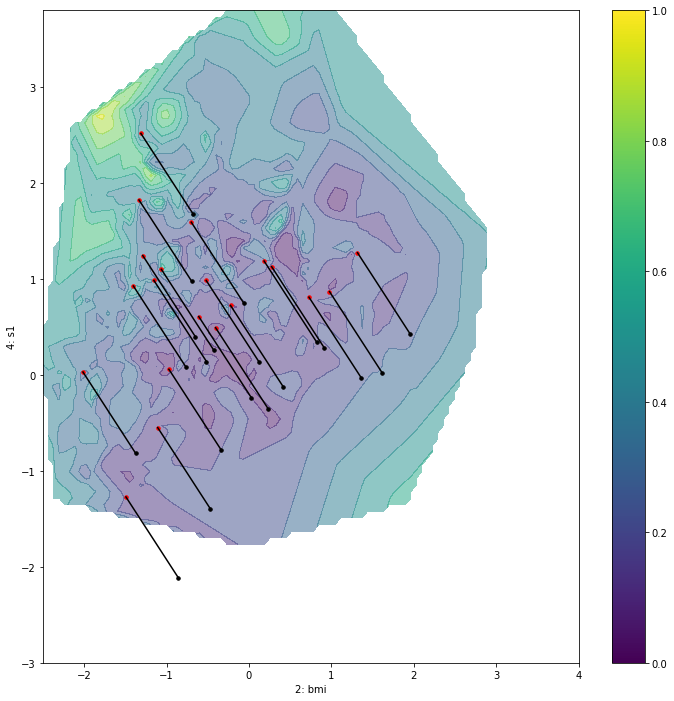

In [15]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]
m_idx = -1

model = models[m_idx]
w_f = model.f.model.linear.weight.detach().numpy().squeeze()


ngridx = 100
ngridy = 100
x1i = np.linspace(-2.5, 4, ngridx)
x2i = np.linspace(-3, 3.8, ngridy)

xp = model.move_points(x,eta,mask)
xp_trn, xp_tst = xp[idx_trn,:], xp[idx_tst,:]
xp1 = xp[:,feats[0]]
xp2 = xp[:,feats[1]]
lb, ub = model.u.predict(xp)
sz = ub-lb

# plt.scatter(x1,sz)
# plt.scatter(x2,sz)
# plt.show()

szi = griddata((xp1, xp2), sz, (x1i[None,:], x2i[:,None]), method='linear')
# szi = gaussian_filter(szi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.contourf(x1i, x2i, szi, levels=10, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')
plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

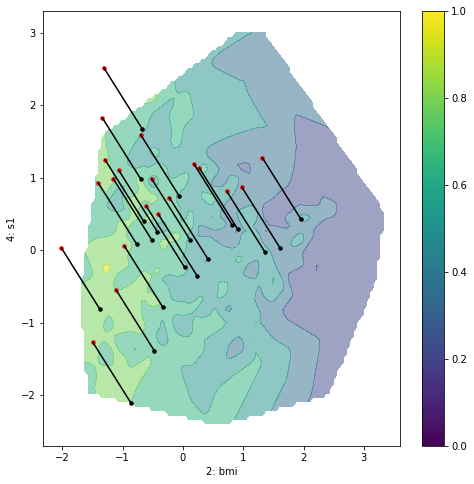

In [16]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]

ngridx = 100
ngridy = 100
x1i = np.linspace(-1.9, 3.6, ngridx)
x2i = np.linspace(-2.7, 3.3, ngridy)

x1 = x[:,feats[0]]
x2 = x[:,feats[1]]

yi = griddata((x1, x2), y, (x1i[None,:], x2i[:,None]), method='linear')
yi = gaussian_filter(yi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.contourf(x1i, x2i, yi, levels=5, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')
plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

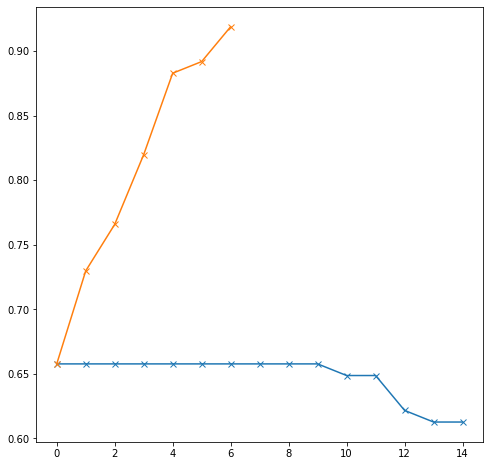

In [17]:
plt.plot(perf_base['imprate'][:,1],'-x')
plt.plot(all_perf_la[0]['imprate'][:,1],'-x')

seed: 1 , eta: 5.0


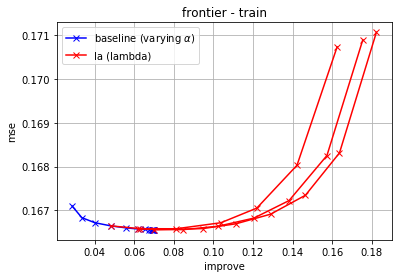

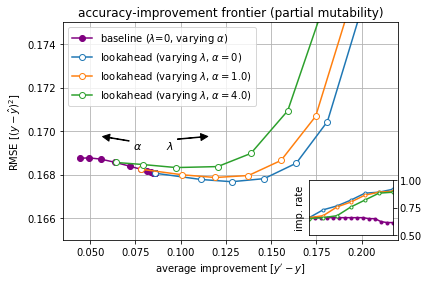

In [18]:
# plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

SAVE_FIG = False
fname = 'diabetes_mask_2-4_v2'

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2)))
alphas_idx = [0, 4, -2]

print('seed:',seed,', eta:',eta)
plt.plot(perf_base['improve'][:,0], np.sqrt(perf_base['mse'][:,0]),'b-x')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'r-x')
# plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend([r'baseline (varying $\alpha$)','la (lambda)'])
plt.grid()
# plt.ylim([0.,0.18])
plt.show()


plt.plot(perf_base['improve'][:,1], np.sqrt(perf_base['mse'][:,1]),'-o',markerfacecolor=None,c='purple')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',markerfacecolor='white')
# plt.plot(perf_naive['improve'][:,1], perf_naive['mse'][:,1],'g-x')
plt.title('accuracy-improvement frontier (partial mutability)')
plt.ylabel('RMSE [$(y-\hat{y})^2$]')
plt.xlabel('average improvement [$y\'-y$]')
plt.legend([r'baseline ($\lambda$=0, varying $\alpha$)',
            *[r'lookahead (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx]],
          loc='upper left')
plt.grid()
plt.ylim([0.165, 0.175])
plt.xlim([0.035,0.22])

xx = perf_base['improve'][0,1]
yy = np.sqrt(perf_base['mse'][0,1])
plt.annotate(r'$\alpha$',
ha = 'center', va = 'bottom',
xytext = (xx-0.01,yy+0.001),
xy = (xx-0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
plt.annotate(r'$\lambda$',
ha = 'center', va = 'bottom',
xytext = (xx+0.008,yy+0.001),
xy = (xx+0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)

ax = plt.gca() 
axins = inset_axes(ax, width="25%", height="25%", loc=4)
axins.plot(np.linspace(0,1,len(alphas)),perf_base['imprate'][:,1],'-o',markerfacecolor=None,c='purple',markersize=3)
for i in alphas_idx:
    axins.plot(np.linspace(0,1,len(lams)),all_perf_la[i]['imprate'][:,1],'-o',markerfacecolor='white',markersize=3)
axins.set_xticks([])
axins.set_yticks([0.5,0.75, 1.0])
axins.yaxis.tick_right()
axins.set_xlim([0,1])
axins.set_ylabel('imp. rate')


plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab10(np.arange(10)))

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

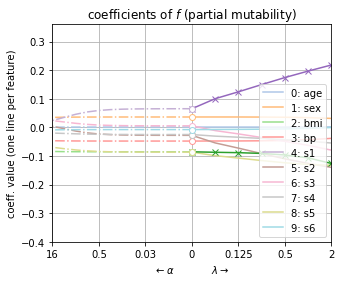

In [19]:
SAVE_FIG = False
# fname = 'wine_mask_ws'


models = all_models[0] #has alpha=0

ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

mask_idx = np.where(mask>0)[0]
non_mask_idx = np.setdiff1d(np.arange(d), mask_idx)

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2)))
for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-') #,alpha=a)
    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-x') #,alpha=a)
    else:
        plt.plot([],[])
        
plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2))))
plt.plot(np.arange(0,-len(alphas),-1)/2,ws_base,'-.') #alpha=0.5)

plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,ws_base[0,i],'o',markerfacecolor='white')

plt.grid()
plt.ylim([-0.4,0.36])
plt.xlim([-6,6])
plt.title('coefficients of $f$ (partial mutability)')
plt.ylabel('coeff. value (one line per feature)')
plt.xlabel(r'$\leftarrow \alpha \qquad \qquad \lambda \rightarrow$')
plt.xticks([-6,-4,-2,0,2,4,6], [16,0.5,0.03,0,0.125,0.5,2])

custom_lines = [Line2D([0], [0], ls='-', marker='x', color='k', lw=1),
                Line2D([0], [0], ls='-', color='k', lw=1),
                Line2D([0], [0], ls='-.', color='k', lw=1)]
plt.legend(custom_lines, ['lookahead (mutable)', 'lookahead (immutable)', 'baseline'],
          loc='upper left', fontsize=9.5)
plt.legend(titles_idx)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

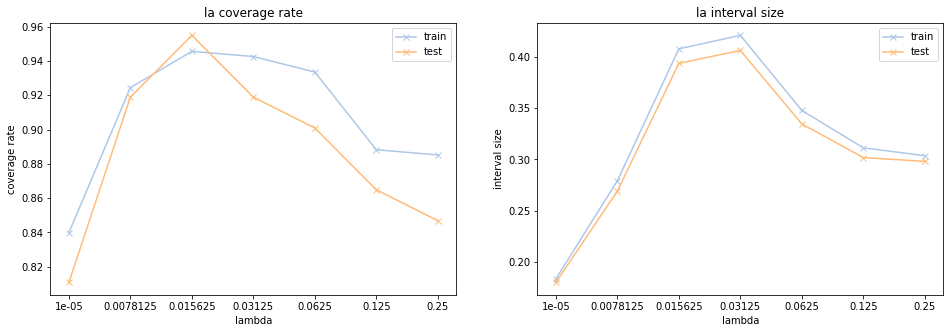

In [20]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_la['contain'][:,:2],'x-')
plt.title('la coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_la['size'][:,:2],'x-')
plt.title('la interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()